<a href="https://colab.research.google.com/github/henrychuks002/Customer-Segmentation-with-AWS/blob/main/Customer_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import sklearn.metrics as metrics
plt.style.use('seaborn-white')
from mpl_toolkits import mplot3d
from mpl_toolkits.mplot3d import Axes3D
from sklearn.cluster import KMeans, MeanShift
from sklearn.mixture import GaussianMixture

%matplotlib inline
pd.set_option('display.max_rows', None)
import warnings
warnings.filterwarnings("ignore")
import seaborn as sns

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px

import plotly.io as pio
pio.renderers.default = "colab"
from sklearn.preprocessing import LabelEncoder
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [ ]:
# from google.colab import files
# files.upload()

**Cleaning the Data**

In [2]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [3]:
#importing the data from the mounted drive
df = pd.read_excel("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/Online Retail.xlsx")
original_df = pd.DataFrame.copy(df)
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [4]:
print(df.shape)
df.info()

(541909, 8)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
#to check the exact amount of missing record in the data
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [6]:
#to check all records that has one or more nan values or just an nan values at all 
missingv_df = df[df.isna().any(axis=1)]
missingv_df.head()

InvoiceNo StockCode  ... CustomerID         Country
622     536414     22139  ...        NaN  United Kingdom
1443    536544     21773  ...        NaN  United Kingdom
1444    536544     21774  ...        NaN  United Kingdom
1445    536544     21786  ...        NaN  United Kingdom
1446    536544     21787  ...        NaN  United Kingdom

[5 rows x 8 columns]

In [7]:
#the different ountries that are present in the data
missingv_df['Country'].unique()

array(['United Kingdom', 'EIRE', 'Bahrain', 'Israel', 'Hong Kong',
       'Unspecified', 'France', 'Switzerland', 'Portugal'], dtype=object)

In [8]:
print('Total number of missing Customer ID ',missingv_df.shape[0])
for i in list(missingv_df['Country'].unique()):
    print("Total number of missing Customer ID for "+i,missingv_df[missingv_df['Country']== i].shape[0])

Total number of missing Customer ID  135080
Total number of missing Customer ID for United Kingdom 133600
Total number of missing Customer ID for EIRE 711
Total number of missing Customer ID for Bahrain 2
Total number of missing Customer ID for Israel 47
Total number of missing Customer ID for Hong Kong 288
Total number of missing Customer ID for Unspecified 202
Total number of missing Customer ID for France 66
Total number of missing Customer ID for Switzerland 125
Total number of missing Customer ID for Portugal 39


In [9]:
df.dropna(axis=0, inplace=True)
df.shape

(406829, 8)

In [10]:
#deleting duplicate record and keeping just one
df.drop_duplicates(list(df.columns), keep='first', inplace=True)
df['CustomerID'] = df['CustomerID'].astype(str)
print(df.shape)
print("Quantity columns contains some negative values {}".format(df[df['Quantity']<0].shape))
#removing negative Quantity values
drop = df[df['Quantity']<0]
index_list = list(drop.index)
df.drop(index_list, inplace=True)
df.describe()

(401604, 8)
Quantity columns contains some negative values (8872, 8)


Quantity      UnitPrice
count  392732.000000  392732.000000
mean       13.153718       3.125596
std       181.588420      22.240725
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max     80995.000000    8142.750000

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe325ba8f50>]],
      dtype=object)

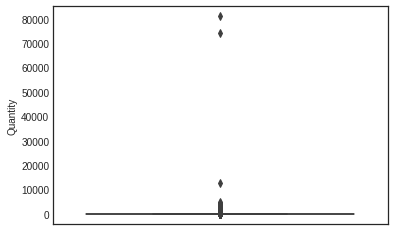

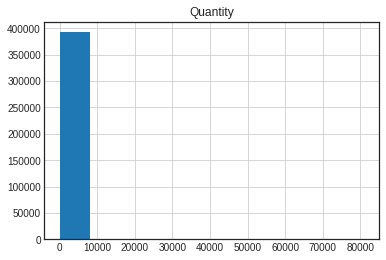

In [11]:
#visualizing Quantity to check for outliers or anomalies
sns.boxplot(y='Quantity', data=df)
print('\n\n')
df.hist(column='Quantity')
#plt.show()

(392729, 8)
14.95
(3723, 8)





array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fe3255a2110>]],
      dtype=object)

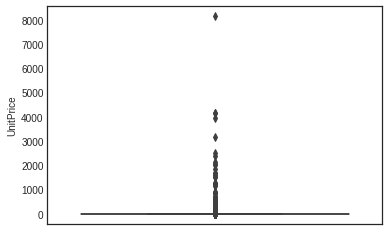

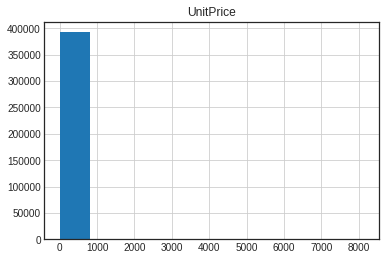

In [12]:
df = df.drop(list(df[df['Quantity']>10000].index), axis=0)
print(df.shape)
print(np.percentile(df['UnitPrice'],[99])[0])
print(df[df['UnitPrice']>np.percentile(df['UnitPrice'],[99])[0]].shape)

#visualizing UnitPrice to check for outliers or anomalies too
sns.boxplot(y='UnitPrice', data=df)
print("\n\n")
df.hist(column='UnitPrice')

In [13]:
'''
Let me tell you the take out from this cell, items at location 144826 and 144828 was bought by the same customer with the same invoice number, at the same time but at different prices
does that make any sense?
makes me feel strange about this "Manual Description"
'''
print(df[df['UnitPrice']>1000].shape)
df[df['UnitPrice']>1000].head()

(21, 8)


InvoiceNo StockCode Description  ...  UnitPrice CustomerID    Country
117054    546328         M      Manual  ...    1687.17    14911.0       EIRE
117055    546329         M      Manual  ...    1687.17    14911.0       EIRE
144826    548813         M      Manual  ...    2382.92    12744.0  Singapore
144828    548813         M      Manual  ...    1252.95    12744.0  Singapore
144829    548820         M      Manual  ...    2053.07    12744.0  Singapore

[5 rows x 8 columns]

In [14]:
df = df.drop(list(df[df['UnitPrice']>1000].index), axis=0)

In [15]:
des = df[df['Description']==df['Description'].str.title()]
#print(des.shape)
#des.head(10)
df = df.drop(list(des.index), axis=0)
print('Dataset shape {} '.format(df.shape))

Dataset shape (392345, 8) 


In [16]:
df.describe()

Quantity      UnitPrice
count  392345.000000  392345.000000
mean       12.721194       2.962478
std        42.942174       5.940544
min         1.000000       0.000000
25%         2.000000       1.250000
50%         6.000000       1.950000
75%        12.000000       3.750000
max      4800.000000     908.160000

**Exploratory Analysis**

In [17]:
df.head()

InvoiceNo StockCode  ... CustomerID         Country
0    536365    85123A  ...    17850.0  United Kingdom
1    536365     71053  ...    17850.0  United Kingdom
2    536365    84406B  ...    17850.0  United Kingdom
3    536365    84029G  ...    17850.0  United Kingdom
4    536365    84029E  ...    17850.0  United Kingdom

[5 rows x 8 columns]

In [18]:
'''
Turns out this dataset wont particularly need much of exploratory analysis
'''
df.corr()

Quantity  UnitPrice
Quantity   1.000000  -0.062079
UnitPrice -0.062079   1.000000

In [19]:
print("number of unique countries {} ".format(df['Country'].nunique()))
print("number of unique customers {} ".format(df['CustomerID'].nunique()))
#px.pie(df, values="CustomerID", names="Country", title="Pie Chart for Customer countries", color_discrete_sequence= px.colors.sequential.RdBu)
# fig = go.Figure(data=[go.Pie(labels=df.Country, values=df.CustomerID, title="Pie Chart for Customer countries", color_discrete_sequence= px.colors.sequential.RdBu)])
# fig.update_layout(margin=dict(t=0, b=0, l=0, r=0))
# fig.show()
print("\n\n")
px_fig = px.histogram(df, x="Country")
px_fig.show()

number of unique countries 37 
number of unique customers 4333 





In [20]:
'''
Turns out that most of potential customers in the data given are from the UK, the table below show a 90% from the UK
One could obviously guess the company that recorded the data would definitely be from the UK
'''
List = []
for i in df['Country'].unique():
  per = len(df[df['Country']==i])/len(df)
  List.append("%.4f"%per)

Map = [[a,b] for (a,b) in zip(list(df['Country'].unique()), List)]
showcase_df = pd.DataFrame(np.array(Map), columns=['Countries', 'Percent(%)'])
showcase_df.head()

Countries Percent(%)
0  United Kingdom     0.8892
1          France     0.0212
2       Australia     0.0030
3     Netherlands     0.0060
4         Germany     0.0230

Building the Model

In [21]:
train_data, test_data = np.split(df.sample(frac=1, random_state=1), [int(0.7*len(df))])
print(train_data.shape, test_data.shape)
#train_data.to_csv("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/train.csv")
#test_data.to_csv("./gdrive/MyDrive/Colab Notebooks/Customer Segmentation/test.csv")

(274641, 8) (117704, 8)


In [40]:
new_train = pd.DataFrame.copy(train_data)
gm_train = pd.DataFrame.copy(train_data)
ms_train = pd.DataFrame.copy(train_data)
rfm_train = pd.DataFrame.copy(train_data)
train_data.head()

InvoiceNo  StockCode  Description  ...  CustomerID  Country  Labels
132534       4229       1467          360  ...         325       35       2
252792       8721       2090          994  ...        3338       35       3
70246        2040        161         3296  ...        1401       35       0
26427         847       1277         1106  ...        3145       35       0
499750      16786       3197         3623  ...        3186       35       1

[5 rows x 8 columns]

In [23]:
encode = LabelEncoder()
for column in list(train_data.columns):
  if train_data[column].dtype == np.object:
    train_data[column] = train_data[column].astype(str)
    train_data[column] = encode.fit_transform(train_data[column])

train_data = train_data[['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice', 'CustomerID', 	'Country']]
train_data.head()

InvoiceNo  StockCode  Description  ...  UnitPrice  CustomerID  Country
132534       4229       1467          360  ...       8.50         325       35
252792       8721       2090          994  ...       6.75        3338       35
70246        2040        161         3296  ...       1.25        1401       35
26427         847       1277         1106  ...      12.75        3145       35
499750      16786       3197         3623  ...       2.95        3186       35

[5 rows x 7 columns]

In [24]:
EM_train = pd.DataFrame.copy(train_data)
Meanshift_train = pd.DataFrame.copy(train_data)

The next two cells will be determining the expected optimal number of clusters for the train dataset in both kmeans and expectation maximization

Elbow Method for determining optimal kmeans clusters
1 : 8401228391358.578
2 : 2714135454523.8345
3 : 1729686000777.3591
4 : 1383995820809.752
5 : 1212044063093.6892
6 : 1123384902525.55
7 : 1055593674590.9191
8 : 996845587388.5579
9 : 938183524584.3173
10 : 880879456434.2615


Silhouette coefficient method for determining optimal kmeans cluster
2: 0.5141251520520642
3: 0.42190183786069574
4: 0.3296362356375873
5: 0.2888388068307155
6: 0.2411085521663676
7: 0.22029289529433235
8: 0.2083936014336658
9: 0.21408362476379653
10: 0.2224464079186948
11: 0.2163837747731828





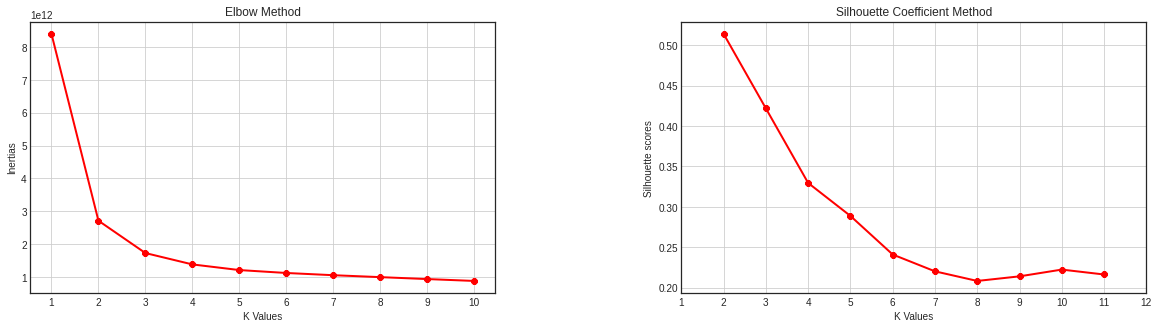

In [ ]:
inertias = []
mapping = {}
for k in range(1, 11):
  kmeans = KMeans(n_clusters = k)
  kmeans.fit(train_data)
  inertias.append(kmeans.inertia_)
  mapping[k] = kmeans.inertia_

print("Elbow Method for determining optimal kmeans clusters")
for key, value in mapping.items():
  print(f'{key} : {value}')


map = {}
scores = []
for i in range(2, 12):
  kmeans_n = KMeans(n_clusters=i, random_state=1)
  labels = kmeans_n.fit(train_data).labels_
  score = metrics.silhouette_score(train_data, labels, metric='euclidean', sample_size=1000, random_state=1)
  scores.append(score)
  map[i] = score

print("\n\nSilhouette coefficient method for determining optimal kmeans cluster")
for key_, val_ in map.items():
  print(f'{key_}: {val_}')

print("\n\n")
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.grid()
plt.plot(range(1,11),inertias, linewidth=2, color="red", marker ="8")
plt.xlabel("K Values")
plt.title("Elbow Method")
plt.xticks(np.arange(1,11,1))
plt.ylabel("Inertias")

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=0.4)
plt.grid()
plt.plot(range(2,12),scores, linewidth=2, color="red", marker ="8")
plt.xlabel("K Values")
plt.title("Silhouette Coefficient Method")
plt.xticks(np.arange(1,13,1))
plt.ylabel("Silhouette scores")

plt.show()

Text(0.5, 0, 'n_components')

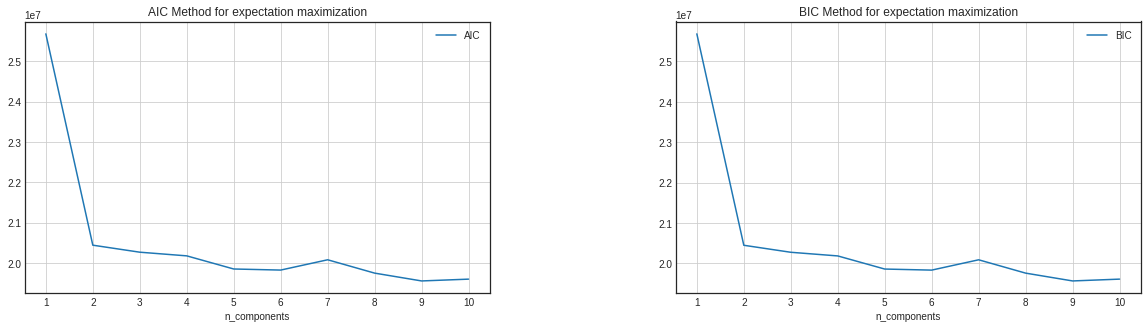

In [ ]:
n_components = np.arange(1, 11)
models = [sklearn.mixture.GaussianMixture(n, covariance_type='full', random_state=0).fit(train_data)
          for n in n_components]

plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.grid()
plt.plot(n_components, [m.aic(train_data) for m in models], label='AIC')
plt.legend(loc='best')
plt.title("AIC Method for expectation maximization")
plt.xticks(np.arange(1,11,1))
plt.xlabel('n_components')

plt.subplot(1,2,2)
plt.subplots_adjust(wspace=0.4)
plt.grid()
plt.plot(n_components, [m.bic(train_data) for m in models], label='BIC')
plt.legend(loc='best')
plt.title("BIC Method for expectation maximization")
plt.xticks(np.arange(1,11,1))
plt.xlabel('n_components')

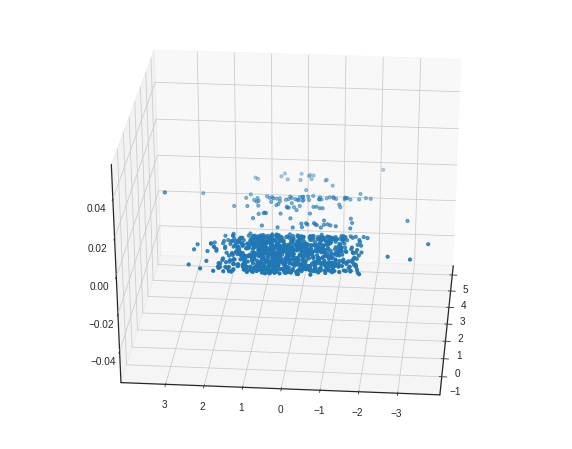

In [25]:
#transforming the data, reducing its dimension to 2 in order to get a visualization of how the data looks
sc = StandardScaler()
scaled_x = sc.fit_transform(train_data)

pca = PCA(n_components=2)
pca.fit(scaled_x)
X = pca.transform(scaled_x)

fig = plt.figure(edgecolor='k', figsize = (10,8))
ax = plt.axes(projection='3d')
ax.scatter(X[:1000,0], X[:1000,1], s=10)
ax.view_init(30,185)

In [47]:
#building the kmeans
clf = KMeans(n_clusters=5, init='random')
clf.fit(train_data)
labels = clf.labels_
cluster_centers = clf.cluster_centers_

In [48]:
train_data['Labels'] = labels
print("Dataset shape ",train_data.shape)
train_data.columns

Dataset shape  (274641, 8)


Index(['InvoiceNo', 'StockCode', 'Description', 'Quantity', 'UnitPrice',
       'CustomerID', 'Country', 'Labels'],
      dtype='object')

In [49]:
new_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
print(new_X.shape)
new_X.head()

(274641, 2)


pca_one   pca_two
0  0.828881  0.047483
1 -0.896245  0.640249
2  0.300352 -1.844498
3 -0.647489 -0.168952
4 -0.906486  2.012623

In [50]:
new_X['labels'] = labels

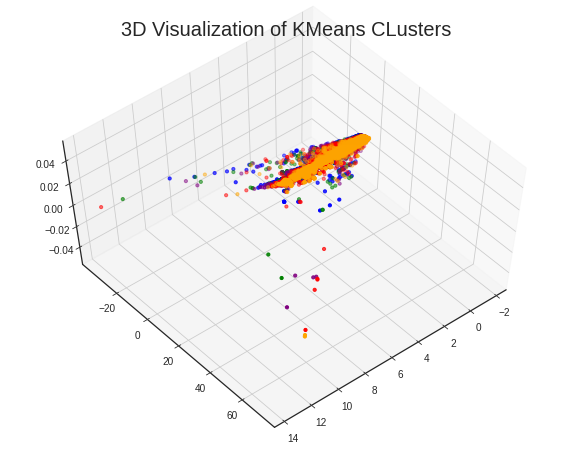

In [51]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(new_X.pca_one[new_X.labels == 0], new_X.pca_two[new_X.labels == 0], c='blue', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 1], new_X.pca_two[new_X.labels == 1], c='red', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 2], new_X.pca_two[new_X.labels == 2], c='green', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 3], new_X.pca_two[new_X.labels == 3], c='orange', s=10)
ax.scatter(new_X.pca_one[new_X.labels == 4], new_X.pca_two[new_X.labels == 4], c='purple', s=10)
ax.set_title("3D Visualization of KMeans CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)
fig.show()

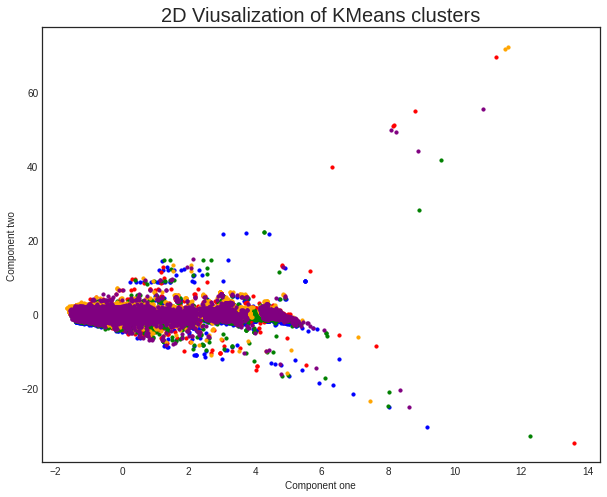

In [52]:
#2d visualization

plt.figure(figsize = (10,8))
plt.scatter(new_X.pca_one[new_X.labels == 0], new_X.pca_two[new_X.labels == 0], c='blue', s=10)
plt.scatter(new_X.pca_one[new_X.labels == 1], new_X.pca_two[new_X.labels == 1], c='red', s=10)
plt.scatter(new_X.pca_one[new_X.labels == 2], new_X.pca_two[new_X.labels == 2], c='green', s=10)
plt.scatter(new_X.pca_one[new_X.labels == 3], new_X.pca_two[new_X.labels == 3], c='orange', s=10)
plt.scatter(new_X.pca_one[new_X.labels == 4], new_X.pca_two[new_X.labels == 4], c='purple', s=10)
plt.title("2D Viusalization of KMeans clusters", fontsize=20)
plt.xlabel("Component one", fontsize=10)
plt.ylabel("Component two", fontsize=10)
plt.show()

In [34]:
gmm_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
print(gmm_X.shape)

(274641, 2)


In [37]:
#building Expectation maximization
gmm = GaussianMixture(n_components=5, covariance_type="full", max_iter=100, init_params='random')
gmm.fit(EM_train)
gmm_labels = gmm.predict(EM_train)

In [42]:
EM_train['Labels'] = gmm_labels
print('Unique label values: ',EM_train.Labels.unique())
print('new Labels size: ',len(EM_train.Labels) )
gmm_X['labels'] = gmm_labels

Unique label values:  [2 0 1 4 3]
new Labels size:  274641


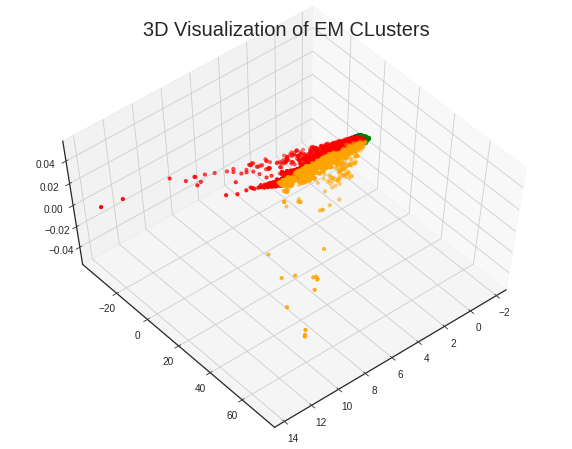

In [46]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(gmm_X.pca_one[gmm_X.labels == 0], gmm_X.pca_two[gmm_X.labels == 0], c='blue', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 1], gmm_X.pca_two[gmm_X.labels == 1], c='red', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 2], gmm_X.pca_two[gmm_X.labels == 2], c='green', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 3], gmm_X.pca_two[gmm_X.labels == 3], c='orange', s=10)
ax.scatter(gmm_X.pca_one[gmm_X.labels == 4], gmm_X.pca_two[gmm_X.labels == 4], c='purple', s=10)
ax.set_title("3D Visualization of EM CLusters", fontdict={'fontsize':20})
ax.view_init(60, 50)
fig.show()

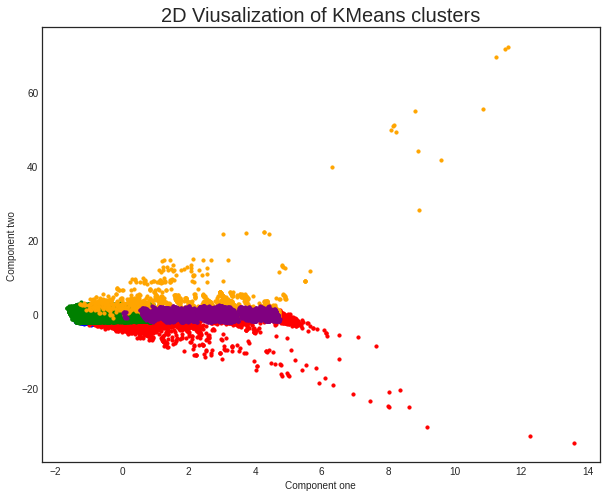

In [45]:
#2D visualiszation of EM clusters

fig = plt.figure(figsize=(10,8))
plt.scatter(gmm_X.pca_one[gmm_X.labels == 0], gmm_X.pca_two[gmm_X.labels == 0], c='blue', s=10)
plt.scatter(gmm_X.pca_one[gmm_X.labels == 1], gmm_X.pca_two[gmm_X.labels == 1], c='red', s=10)
plt.scatter(gmm_X.pca_one[gmm_X.labels == 2], gmm_X.pca_two[gmm_X.labels == 2], c='green', s=10)
plt.scatter(gmm_X.pca_one[gmm_X.labels == 3], gmm_X.pca_two[gmm_X.labels == 3], c='orange', s=10)
plt.scatter(gmm_X.pca_one[gmm_X.labels == 4], gmm_X.pca_two[gmm_X.labels == 4], c='purple', s=10)
plt.title("2D Viusalization of EM clusters", fontsize=20)
plt.xlabel("Component one", fontsize=10)
plt.ylabel("Component two", fontsize=10)
plt.show()

In [57]:
# ms_X = pd.DataFrame(X, columns=["pca_one","pca_two"])
# ms = MeanShift()
# ms.fit(Meanshift_train)